In [1]:
suppressPackageStartupMessages({
    library(ggtree)
    library(phytools)
    library(ggvenn)
    require(igraph)
})

In [3]:
# load latest version of orthofinder results
OGs <- read.delim("/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/02.gene_relationships/run4/results/Ortho_pipeline/OrthoFinder/Orthogroups/Orthogroups.tsv", header = T, sep = "\t")

In [4]:
species <- c("Hsap" , "Mmus", "Ggal", "Pvit", "Pmar", "Bflo")

In [5]:
number_of_genes <- Reduce(rbind, lapply(species, FUN = function(s){
        paralogs <- Reduce(rbind, lapply(1:nrow(OGs), FUN = function(i){
            id_ <- stringr::str_split(OGs[i, s], ", ")[[1]]
            table <- data.frame(no = i, number = length(id_))
            return(table)
        }))
    paralogs$species <- s
    return(paralogs)
}))

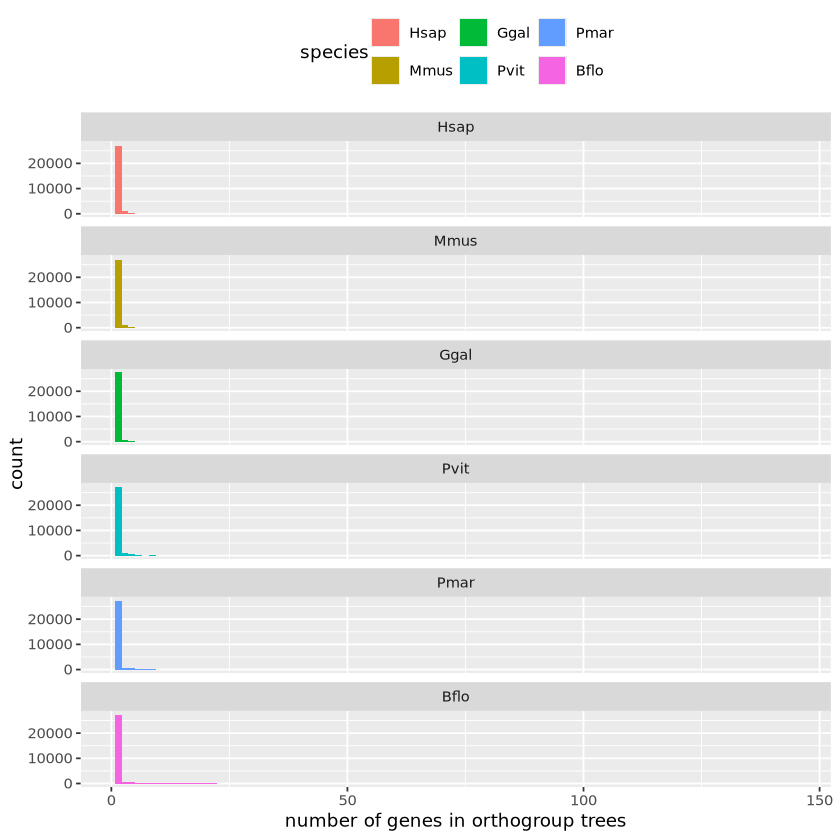

In [6]:
number_of_genes$species <- factor(number_of_genes$species, levels = species)
ggplot(number_of_genes, aes(x=number, fill = species)) +
    geom_histogram(bins = 100) + theme(legend.position="top") + facet_wrap(~ species, nrow = 6) + 
    xlab("number of genes in orthogroup trees")

In [7]:
results <- lapply(species, FUN = function(s){
    paralogs <- Reduce(rbind, lapply(1:nrow(OGs), FUN = function(i){
        id_ <- stringr::str_split(OGs[i, s], ", ")[[1]]
        if (length(id_) >=2 & length(id_) <= 30){
            # maybe ignore orthogroups contain too many copies (15) within single species? no need to
            # only dozens of orthogroups will be filtered for each species if we do
            id_ <- combn(id_, 2)
            table <- data.frame(Dup1 = id_[1,], Dup2 = id_[2,])
            return(table)
        } else {
            return(NULL)
        }
    }))
    return(paralogs)
})
names(results) <- species

In [8]:
# store paralog results for each species
lapply(species, FUN = function(s){
    write.table(results[[s]], file = paste0(s, ".paralogs.txt"), col.names = T, row.names = F, quote = F, sep = "\t")
})

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

In [9]:
# compare to Ensembl version:
path <- "/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/01.data/04.paralogs_Ensembl/"
Ensembl_info <- lapply(c("human", "mouse", "lizard"), FUN = function(s){
    file = paste0(path, "Ensembl.Biomart.Paralogs_", s, ".txt")
    paralogs <- read.delim(file, header = T, sep = ",")
    s = sub("(.)", "\\U\\1", s, perl = TRUE) # uppercase of first letter
    colnames(paralogs) <- vapply(colnames(paralogs), FUN = function(x){
        gsub(paste0("\\.?", s ,"\\.?"), "", x)
    }, FUN.VALUE = character(1))
    
    paralogs <- paralogs[which(paralogs$Gene.stable.ID != "" & paralogs$paralogue.gene.stable.ID != ""), ]
    #paralogs <- paralogs[paralogs$paralogue.homology.type == "within_species_paralog", ]
    paralogs <- paralogs[,c(1,3)]
    colnames(paralogs) <- c("Dup1", "Dup2")
    return(paralogs)
})

names(Ensembl_info) <- c("Hsap", "Mmus", "Pvit")

In [31]:
# plot set of paralog genes vs Ensembl paralogs
for (s in c("Hsap", "Mmus", "Pvit")){
    mine <- unique(c(results[[s]]$Dup1, results[[s]]$Dup2))
    ensembl <- unique(c(Ensembl_info[[s]]$Dup1, Ensembl_info[[s]]$Dup2))
    p <- ggvenn(list(my_version=mine, Ensembl_paralogs = ensembl), text_size = 6)
    ggsave(filename = paste0(s, ".all_pairs.comparison.pdf"), plot = p, device = "pdf", width = 5, height = 5)
    #ggsave(filename = paste0(s, ".wo_remote_paralogs.comparison.pdf"), plot = p, device = "pdf", width = 5, height = 5)
}

In [ ]:
# for comparing within species paralog of Ensembl, pay attention to above #

In [13]:
# comparing in paralog families
path <- "/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/03.paralog_inferring/v1/"
mine <- lapply(c("Hsap", "Mmus", "Pvit", "Pmar", "Bflo"), FUN = function(s){
    file = paste0(path, s, ".paralogs.txt")
    paralogs <- read.delim(file, header = T, sep = "\t")
    return(paralogs)
})
names(mine) <- c("Hsap", "Mmus", "Pvit", "Pmar", "Bflo")

In [14]:
Reduce(rbind, lapply(c("Hsap", "Mmus", "Pvit"), FUN = function(s){

    my <- mine[[s]]
    Ensembl <- Ensembl_info[[s]]
    
    g <- graph_from_data_frame(my[,c(1,2)], directed = FALSE)
    components <- clusters(g)$membership
    my_pairs <- split(names(components), components)
    my_mean <- mean(unlist(lapply(seq_along(my_pairs), FUN = function(x){
        length(my_pairs[[x]])
    })))
    
    g <- graph_from_data_frame(Ensembl[,c(1,2)], directed = FALSE)
    components <- clusters(g)$membership
    Ensembl_pairs <- split(names(components), components)
    Ensembl_mean <- mean(unlist(lapply(seq_along(Ensembl_pairs), FUN = function(x){
        length(Ensembl_pairs[[x]])
    })))
    
    data.frame(mine = length(my_pairs), Ensembl = length(Ensembl_pairs), mean1 = my_mean, mean2 = Ensembl_mean, species = s)
    
}))

mine,Ensembl,mean1,mean2,species
<int>,<int>,<dbl>,<dbl>,<chr>
3968,2843,3.000252,5.476257,Hsap
3862,3211,3.458571,6.858300,Mmus
3617,2840,2.935029,5.405282,Pvit
